# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10))

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear_relu_stack(x)
        return x

class Normalize(nn.Module):
    def forward(self, x): 
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [2]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, label, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    model.eval()
    # x.requires_grad_()
    output = model(x)
    loss = F.cross_entropy(output, label)

    grad = torch.autograd.grad(
                loss, x, retain_graph=False, create_graph=False
            )[0]

    x_adv = x.detach() + eps * torch.sign(grad)
    return x_adv



def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    
    model.eval()
    adv_images = x.clone().detach()
    for _ in range(k):
        adv_images.requires_grad = True
        x_adv = fgsm(model, adv_images, y, eps_step)
        delta = torch.clamp(x_adv - x, min=-eps, max=eps)
        adv_images = torch.clamp(x + delta, min = 0, max = 1)
    
    return adv_images


# Implement Adversarial Training

In [3]:
def train_model(model, train_loader, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    model.train()

    lr = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        for index, (images, labels) in enumerate(train_loader):
            logits = model(images)
            optimizer.zero_grad()

            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

    if enable_defense:
            for epoch in range(num_epochs):
                for index, (images, labels) in enumerate(train_loader):
                    adversary_images = pgd_untargeted(model, images, labels, 10,  eps, 0.01)
                    model.train()
                    optimizer.zero_grad()
                    logits = model(adversary_images)
                    loss = F.cross_entropy(logits, labels)
                    loss.backward()
                    optimizer.step()
                    
                print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

In [4]:

def test_model_on_attacks(model, attack='pgd', eps=0.1):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function
    correct = 0
    model.eval()
    for j, (images, labels) in enumerate(test_loader):
        images, labels = images, labels
        adversarial_images = pgd_untargeted(model, images, labels, 20, eps, 0.01)        
        logits = model(adversarial_images)
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
    model.train()
    print('Accuracy = {}%'.format(float(correct) * 100 / 10000))
    

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

## Standard Training

In [ ]:
## train the original model
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

train_model(model, train_loader, 30, False)
torch.save(model.state_dict(), 'standard-weights.pt')

4


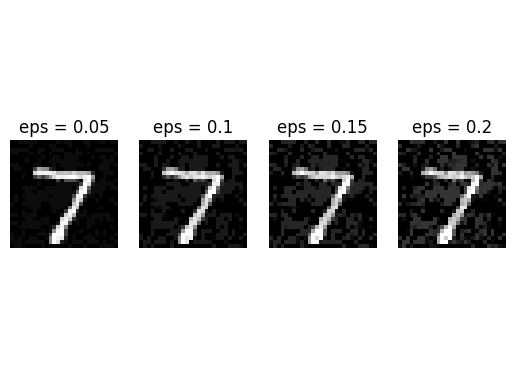

In [145]:
adv_images = []
epss= [0.05, 0.1, 0.15, 0.2]
for eps in epss:
    for j, (images, labels) in enumerate(test_loader):
        images, labels = images, labels
        adv_image = pgd_untargeted(model, images, labels, 20, eps, 0.01)  
        break
    adv_images.append(adv_image[0])
print(len(adv_images))
# sample_img , sample_lbl = temp_train_dataset[3]
figure = plt.figure()
cols, rows = 4, 1
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    plt.axis('off')
    figure.add_subplot(rows, cols, i)

    plt.title(f'eps = {epss[i - 1]}')
    plt.imshow(adv_images[i - 1].squeeze(), cmap="gray")
plt.axis('off')
plt.show()


### Standard Accuracy

In [95]:
correct = 0
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

Accuracy = 98.18%


### Accuracy on Adversarial Set

In [21]:
## PGD attack
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('standard-weights.pt', weights_only=True))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='pgd', eps=eps)

Accuracy = 72.81%
Accuracy = 14.52%
Accuracy = 2.86%
Accuracy = 1.11%


### Robust Accuracy

In [113]:
correct = 0
eps = 0.1
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  adv_images = pgd_untargeted(model, images, labels, 20, eps, 0.01)  
  logits = model(images)
  adv_logits = model(adv_images)
  _, preds = torch.max(logits, 1)
  _, adv_preds = torch.max(adv_logits, 1)
  correct += (preds == labels).sum().item()
  correct += (adv_preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 20000))

Accuracy = 55.875%


## Adversarial Training

In [ ]:
## PGD based adversarial training
adv_train_model = nn.Sequential(Normalize(), Net())
eps = 0.1
train_model(adv_train_model, train_loader, 20, True, 'pgd', eps)
torch.save(adv_train_model.state_dict(), f'weights_AT_{eps}.pt')

In [22]:
model = nn.Sequential(Normalize(), Net())
model.load_state_dict(torch.load('weights_AT_0.1.pt', weights_only=True))

<All keys matched successfully>

### Standard Accuracy

In [23]:
correct = 0
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

Accuracy = 98.05%


### Accuracy on Adversarial Set

In [25]:
## PGD attack
for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model_on_attacks(model, attack='pgd', eps=eps)

Accuracy = 95.6%
Accuracy = 89.46%
Accuracy = 75.76%
Accuracy = 52.83%


### Robust Accuracy

In [124]:
correct = 0
eps = 0.1
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  adv_images = pgd_untargeted(model, images, labels, 20, eps, 0.01)  
  logits = model(images)
  adv_logits = model(adv_images)
  _, preds = torch.max(logits, 1)
  _, adv_preds = torch.max(adv_logits, 1)
  correct += (preds == labels).sum().item()
  correct += (adv_preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 20000))

Accuracy = 93.755%


In [5]:
adv_model = nn.Sequential(Normalize(), Net())
adv_model.load_state_dict(torch.load('weights_AT_0.1.pt', weights_only=True))

<All keys matched successfully>

In [28]:
correct = 0
eps = 0.1
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  images.requires_grad = True
  adv_images = fgsm(model, images, labels, 0.1) 
  logits = model(images)
  adv_logits = model(adv_images)
  _, preds = torch.max(logits, 1)
  _, adv_preds = torch.max(adv_logits, 1)
  correct += (preds == labels).sum().item()
  correct += (adv_preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 20000))

Accuracy = 92.15%


In [65]:
from torchattacks.attacks.tpgd import TPGD
from torchattacks.attacks.gn import GN


In [59]:
correct = 0
eps = 0.1
model.eval()
for j, (images, labels) in enumerate(test_loader):
  attack = TPGD(adv_model,eps=8/255, alpha=2/255, steps=10)
  adv_images = attack(images)
  logits = adv_model(images)
  adv_logits = adv_model(adv_images)
  _, preds = torch.max(logits, 1)
  _, adv_preds = torch.max(adv_logits, 1)
  correct += (preds == labels).sum().item()
  correct += (adv_preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 20000))

Accuracy = 97.93%


In [67]:
correct = 0
eps = 0.1
adv_model.eval()
for j, (images, labels) in enumerate(test_loader):
  attack = GN(adv_model)
  adv_images = attack(images)
  logits = adv_model(images)
  adv_logits = adv_model(adv_images)
  _, preds = torch.max(logits, 1)
  _, adv_preds = torch.max(adv_logits, 1)
  correct += (preds == labels).sum().item()
  correct += (adv_preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 20000))

Accuracy = 98.105%
